In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۵ — درخت‌های تصمیم و گونه‌ها
## درس ۲: CART (درخت‌های طبقه‌بندی و رگرسیون)

**هدف:** رسیدن به یک درک *عملی و قابل‌پیاده‌سازی* از CART؛ از معیارهای شکاف و هرس‌سازی تا ساخت پایپلاین‌های قابل‌اعتماد برای طبقه‌بندی و رگرسیون روی داده‌های جدولی.

**در این درس یاد می‌گیرید:**
- CART را به‌عنوان «تقسیم‌بندی دودویی بازگشتی و حریصانه» توضیح دهید.
- کیفیت شکاف را با **Gini / Entropy** (برای طبقه‌بندی) و **MSE / کاهش واریانس** (برای رگرسیون) محاسبه کنید.
- بیش‌برازش را با **هرس‌سازی پیشین** (محدودیت عمق/برگ) و **هرس‌سازی پسین** (**هرس‌سازی پیچیدگی-هزینه**) کنترل کنید.
- `DecisionTreeClassifier` و `DecisionTreeRegressor` را با تفکیک درست آموزش/آزمون و اعتبارسنجی متقابل آموزش و ارزیابی کنید.
- ویژگی‌های رده‌ای و مقادیر گمشده را با **پایپلاین‌ها** مدیریت کنید.
- مدل را با اهمیت ویژگی، اهمیت جابه‌جایی (Permutation) و مسیر تصمیم (Decision Path) تفسیر کنید.

> **نمادگذاری**: در این نوت‌بوک فقط از LaTeX به‌شکل `$...$` و `$$...$$` استفاده می‌شود (نه `\( ... \)` / `\[ ... \]`).


## ۱) CART چیست؟

**CART** مخفف **Classification And Regression Trees** است. این خانواده از *درخت‌های تصمیم دودویی* برای هر دو مسئله‌ی زیر از یک ایده‌ی الگوریتمی مشترک استفاده می‌کند:

- **طبقه‌بندی:** پیش‌بینی یک برچسب گسسته (مثل Diabetic / Non-Diabetic)
- **رگرسیون:** پیش‌بینی یک مقدار عددی (مثل قیمت خانه)

### ۱.۱ تقسیم‌بندی دودویی بازگشتی

درخت CART فضای ویژگی را با دنباله‌ای از پرسش‌هایی از جنس زیر تقسیم می‌کند:

- $x_j \le t$  (برای ویژگی عددی $x_j$ و آستانه‌ی $t$)
- یا برای داده‌های رده‌ای (پس از کدگذاری) در عمل پرسش‌هایی شبیه «آیا ویژگی در یک زیرمجموعه هست؟» (در عمل معمولاً **one-hot** می‌کنیم و سپس پرسش‌های $0/1$ می‌پرسیم)

در هر گره‌ی داخلی، بهترین شکاف از بین گزینه‌ها با یک هدف حریصانه انتخاب می‌شود.

### ۱.۲ هدف حریصانه‌ی شکاف

در یک گره با مجموعه‌داده‌ی $S$، CART شکاف $(j,t)$ را طوری انتخاب می‌کند که **ناخالصیِ وزن‌دار** را کمینه کند:

$$
\text{Score}(S, j, t) = \frac{|S_L|}{|S|} I(S_L) + \frac{|S_R|}{|S|} I(S_R),
$$

که در آن $S_L=\{x\in S: x_j\le t\}$ و $S_R = S\setminus S_L$ و $I(\cdot)$ تابع ناخالصی/زیان است.

- برای **طبقه‌بندی** معمولاً $I$ برابر **Gini** یا **Entropy** است
- برای **رگرسیون** معمولاً $I$ برابر **MSE** (یا معادل آن «واریانس») است

> CART **کوتاه‌بین** است: در هر گره بهترین شکاف محلی را انتخاب می‌کند و به‌دنبال بهترین درخت سراسری نیست (یافتن بهترین درخت به‌صورت دقیق از نظر محاسباتی دشوار است).

### ۱.۳ قاعده‌ی پیش‌بینی در برگ‌ها

- **طبقه‌بندی:** برگ تعداد هر کلاس را ذخیره می‌کند و **کلاس غالب** را خروجی می‌دهد؛ برآورد احتمال کلاس: $\hat p_k = n_k / n$.
- **رگرسیون:** برگ **میانگین** (و گاهی میانه) اهداف در آن برگ را خروجی می‌دهد.

---



## ۲) معیارهای شکاف در CART

### ۲.۱ ناخالصی طبقه‌بندی: Gini و Entropy

فرض کنید در یک گره، نسبت کلاس‌ها $(p_1,\dots,p_K)$ باشد.

**ناخالصی Gini:**
$$
G = 1 - \sum_{k=1}^K p_k^2
$$

**آنتروپی:**
$$
H = -\sum_{k=1}^K p_k \log_2(p_k)
$$

شهود:
- Gini شبیه «انتظار خطای طبقه‌بندی» تحت برچسب‌گذاری تصادفی با توزیع همان گره است.
- Entropy میزان عدم‌قطعیت (اطلاعات) را اندازه می‌گیرد.

در CART کلاسیک، برای طبقه‌بندی معمولاً **Gini** استفاده می‌شود، هرچند بسیاری از کتابخانه‌ها اجازه‌ی انتخاب می‌دهند.

### ۲.۲ ناخالصی رگرسیون: MSE / کاهش واریانس

در گره‌ای با اهداف $y_1,\dots,y_n$، رگرسیون CART معمولاً از **مجموع مربعات خطا** (SSE) یا میانگین مربعات خطا استفاده می‌کند:

$$
\text{SSE}(S) = \sum_{i\in S} (y_i - \bar y_S)^2,
\quad
\bar y_S = \frac{1}{|S|}\sum_{i\in S} y_i.
$$

یک شکاف زمانی خوب است که SSE را *کاهش* دهد:

$$
\Delta = \text{SSE}(S) - \left( \text{SSE}(S_L) + \text{SSE}(S_R) \right).
$$

این دقیقاً همان «کاهش واریانس» است، چون $\text{SSE}(S) = |S|\cdot \text{Var}(S)$ (تا یک ضریب ثابت).

### ۲.۳ چرا درخت‌ها به مقیاس‌بندی نیاز ندارند؟

درخت تصمیم ویژگی‌ها را با آستانه‌ها مقایسه می‌کند (مبتنی بر ترتیب). مقیاس‌بندی معمولاً ترتیب را تغییر نمی‌دهد، بنابراین **درخت‌ها عمدتاً نسبت به مقیاس مقاوم‌اند**.
اما پایپلاین‌ها هنوز مهم‌اند برای:
- پیش‌پردازش یکسان و قابل‌تکرار
- مدیریت مقادیر گمشده و ویژگی‌های رده‌ای
- جلوگیری از نشت داده

---



## ۳) بیش‌برازش و هرس‌سازی در درخت‌ها

یک درخت عمیق می‌تواند داده‌ی آموزش را حفظ کند:
- خطای آموزش با افزایش عمق معمولاً $\downarrow$
- خطای آزمون اغلب به‌دلیل واریانس، رفتار **U شکل** دارد

### ۳.۱ هرس‌سازی پیشین (توقف زودهنگام)

ابرپارامترهای رایج:
- `max_depth`: بیشینه‌ی عمق
- `min_samples_split`: حداقل نمونه برای شکستن یک گره داخلی
- `min_samples_leaf`: حداقل نمونه در یک برگ
- `max_leaf_nodes`: سقف تعداد برگ‌ها
- `min_impurity_decrease`: شکاف فقط اگر ناخالصی را به‌اندازه کافی کاهش دهد

این‌ها مانند منظم‌سازی عمل می‌کنند و پیچیدگی را محدود می‌سازند.

### ۳.۲ هرس‌سازی پسین: هرس‌سازی پیچیدگی-هزینه (CART)

CART دنباله‌ای از زیر‌درخت‌ها را با کمینه‌کردن تابع زیر تعریف می‌کند:

$$
R_\alpha(T) = R(T) + \alpha |T|,
$$

که در آن:
- $R(T)$ زیان آموزش (مثلاً خطای طبقه‌بندی یا SSE) است
- $|T|$ تعداد برگ‌های نهایی است
- $\alpha \ge 0$ ضریب جریمه‌ی پیچیدگی است

$\alpha$ بزرگ‌تر، درخت کوچک‌تر می‌دهد.

در scikit-learn این کار با `ccp_alpha` انجام می‌شود و معمولاً با اعتبارسنجی/اعتبارسنجی متقابل تنظیم می‌شود.

---


## ۴) آماده‌سازی پایتون

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance

# scikit-learn 1.4+ deprecates root_mean_squared_error(...).
# Use root_mean_squared_error if available, otherwise fall back to sqrt(MSE).
try:
    from sklearn.metrics import root_mean_squared_error
except Exception:
    def root_mean_squared_error(y_true, y_pred):
        return float(mean_squared_error(y_true, y_pred) ** 0.5)

np.random.seed(42)



## ۴) بارگذاری داده‌ها (در این درس چندین دیتاست استفاده می‌کنیم)

برای این درس عمداً فقط از یک دیتاست استفاده نمی‌کنیم. CART را روی چند دیتاست جدولی از مخزن شما تمرین می‌کنیم:

- **طبقه‌بندی:** `diabetes.csv` ، `Wine_Quality.csv`
- **طبقه‌بندی رده‌ای:** `drug200.csv` (ویژگی‌های رشته‌ای/رده‌ای)
- **رگرسیون:** `house-prices.csv` ، `diamonds.csv`

تمام مسیرها نسبت به محل این نوت‌بوک هستند (`Tutorials/Persian/Chapter5/`).

---


### ۴.۱ بارگذاری `diabetes.csv` (طبقه‌بندی)

In [3]:
# Classification dataset: diabetes
path_diabetes = "../../../Datasets/Classification/diabetes.csv"
df_diabetes = pd.read_csv(path_diabetes)
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


### ۴.۲ تفکیک آموزش/آزمون + یک طبقه‌بند CART پایه

In [4]:
# Basic preprocessing for diabetes
# Target column is 'classification' (Diabetic / Non-Diabetic)
X = df_diabetes.drop(columns=["classification"])
y = df_diabetes["classification"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Save diabetes split variables to prevent feature-name mismatches later in the notebook
X_train_diabetes = X_train.copy()
X_test_diabetes = X_test.copy()
y_train_diabetes = y_train.copy()
y_test_diabetes = y_test.copy()
feature_names_diabetes = list(X.columns)

# Trees don't need scaling, but we still build a pipeline for discipline and missing-value safety.
clf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(random_state=42))
])

clf

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model', DecisionTreeClassifier(random_state=42))])

In [5]:
# Train a baseline CART classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.6822916666666666

In [6]:
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    Diabetic       0.55      0.49      0.52        67
Non-Diabetic       0.74      0.78      0.76       125

    accuracy                           0.68       192
   macro avg       0.65      0.64      0.64       192
weighted avg       0.68      0.68      0.68       192

Confusion matrix:
 [[33 34]
 [27 98]]


### ۴.۳ ROC-AUC (اختیاری)

In [7]:
# Optional: AUC requires probability estimates and a positive class definition
proba = clf.predict_proba(X_test)
classes = clf.named_steps["model"].classes_
classes

array(['Diabetic', 'Non-Diabetic'], dtype=object)

ROC-AUC (Diabetic as positive): 0.6382686567164179


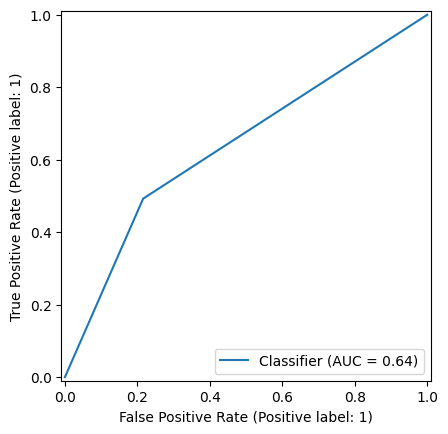

In [8]:
# If 'Diabetic' exists, compute ROC-AUC for that as positive class
if "Diabetic" in classes:
    pos_idx = list(classes).index("Diabetic")
    auc = roc_auc_score((y_test == "Diabetic").astype(int), proba[:, pos_idx])
    print("ROC-AUC (Diabetic as positive):", auc)
    RocCurveDisplay.from_predictions((y_test == "Diabetic").astype(int), proba[:, pos_idx])
    plt.show()
else:
    print("Diabetic class not found; classes =", classes)


## ۵) مصورسازی و تفسیر یک طبقه‌بند CART

دو روش عملی برای «دیدن» درخت:
- `plot_tree` (نمایش گرافیکی)
- `export_text` (قواعد متنی)

برای درخت‌های بزرگ، معمولاً نمایش را با محدودکردن عمق (مثلاً `max_depth=3`) خواناتر می‌کنیم.

---


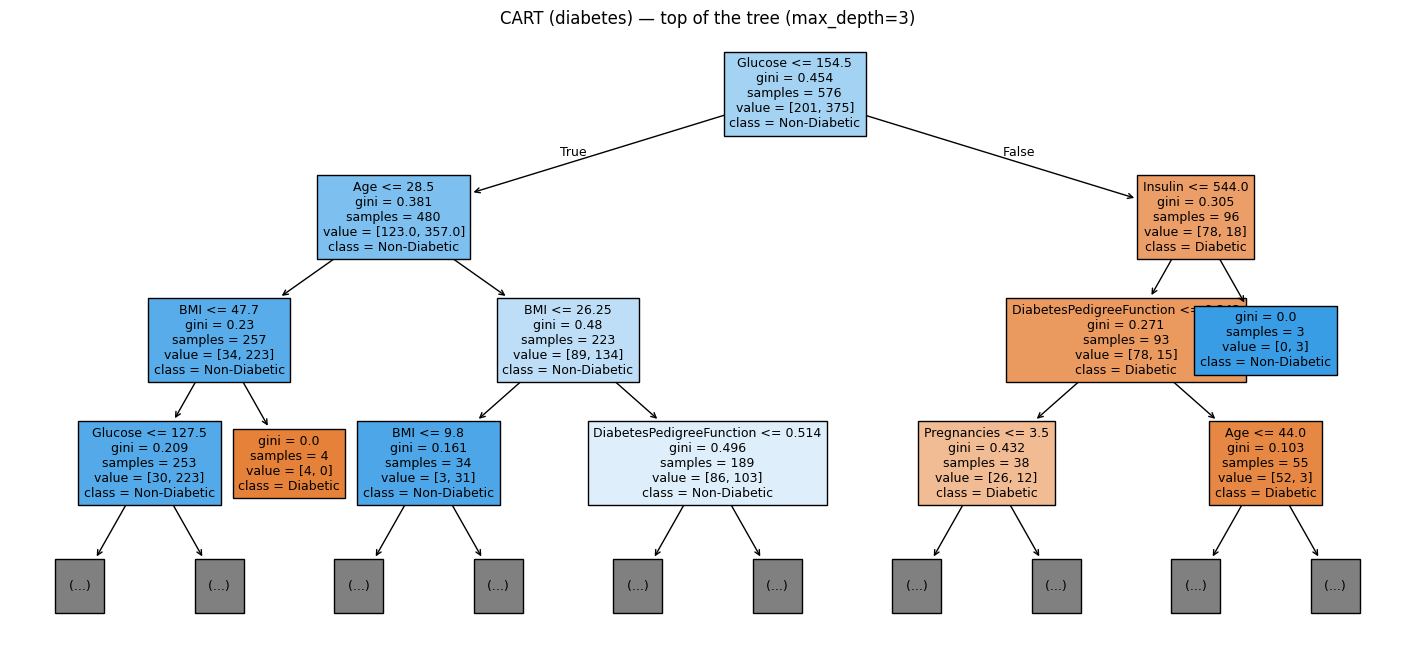

In [9]:
model = clf.named_steps["model"]

plt.figure(figsize=(18, 8))
plot_tree(
    model,
    feature_names=X.columns.tolist(),
    class_names=model.classes_.tolist(),
    filled=True,
    max_depth=3,
    fontsize=9
)
plt.title("CART (diabetes) — top of the tree (max_depth=3)")
plt.show()

In [10]:
print(export_text(model, feature_names=list(X.columns)))

|--- Glucose <= 154.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 47.70
|   |   |   |--- Glucose <= 127.50
|   |   |   |   |--- BMI <= 30.95
|   |   |   |   |   |--- Pregnancies <= 7.50
|   |   |   |   |   |   |--- class: Non-Diabetic
|   |   |   |   |   |--- Pregnancies >  7.50
|   |   |   |   |   |   |--- class: Diabetic
|   |   |   |   |--- BMI >  30.95
|   |   |   |   |   |--- DiabetesPedigreeFunction <= 0.74
|   |   |   |   |   |   |--- BMI <= 31.10
|   |   |   |   |   |   |   |--- class: Diabetic
|   |   |   |   |   |   |--- BMI >  31.10
|   |   |   |   |   |   |   |--- BMI <= 45.40
|   |   |   |   |   |   |   |   |--- BloodPressure <= 22.00
|   |   |   |   |   |   |   |   |   |--- class: Diabetic
|   |   |   |   |   |   |   |   |--- BloodPressure >  22.00
|   |   |   |   |   |   |   |   |   |--- Insulin <= 36.50
|   |   |   |   |   |   |   |   |   |   |--- Insulin <= 34.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |  


## ۶) اهمیت ویژگی: بر پایه ناخالصی در برابر اهمیت جابه‌جایی (Permutation)

### ۶.۱ اهمیت مبتنی بر ناخالصی (داخلی)
درخت می‌تواند اهمیت ویژگی را بر اساس مجموع کاهش ناخالصی منتسب به هر ویژگی در کل درخت گزارش کند.

محدودیت‌ها:
- تمایل به ویژگی‌هایی با نقاط شکاف زیاد (ویژگی‌های پیوسته)
- در حضور هم‌بستگی ویژگی‌ها ممکن است گمراه‌کننده باشد

### ۶.۲ اهمیت جابه‌جایی (پیشنهادی)
Permutation importance افت عملکرد را پس از درهم‌زدن یک ویژگی می‌سنجد. این روش مدل‌-ناوابسته است و معمولاً بیانگر «وابستگی پیش‌بینی» واقعی‌تر است.

---


In [11]:
# Impurity-based importance
imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(10)

Glucose                     0.316992
Age                         0.158995
BMI                         0.133038
DiabetesPedigreeFunction    0.118528
BloodPressure               0.082997
Pregnancies                 0.071315
Insulin                     0.067213
SkinThickness               0.050922
dtype: float64

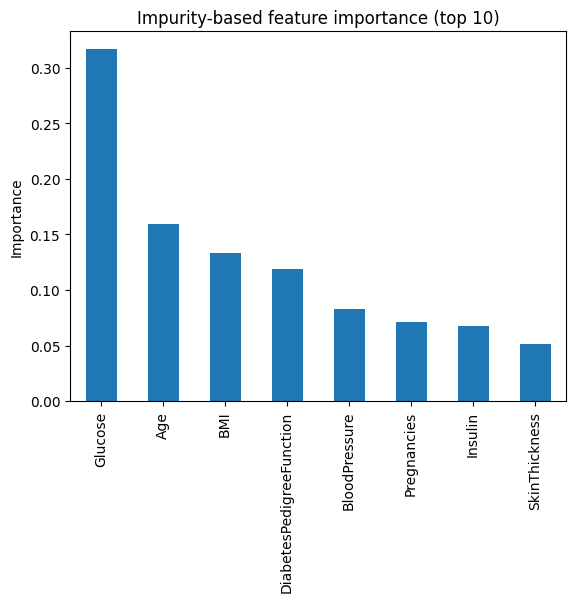

In [12]:
imp.head(10).plot(kind="bar")
plt.title("Impurity-based feature importance (top 10)")
plt.ylabel("Importance")
plt.show()

In [13]:
# Permutation importance on the test set
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, scoring="accuracy"
)
perm = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
perm.head(10)

Glucose                     0.082292
Pregnancies                 0.043750
BMI                         0.035417
Age                         0.027604
DiabetesPedigreeFunction    0.002604
SkinThickness              -0.002083
Insulin                    -0.007292
BloodPressure              -0.015625
dtype: float64

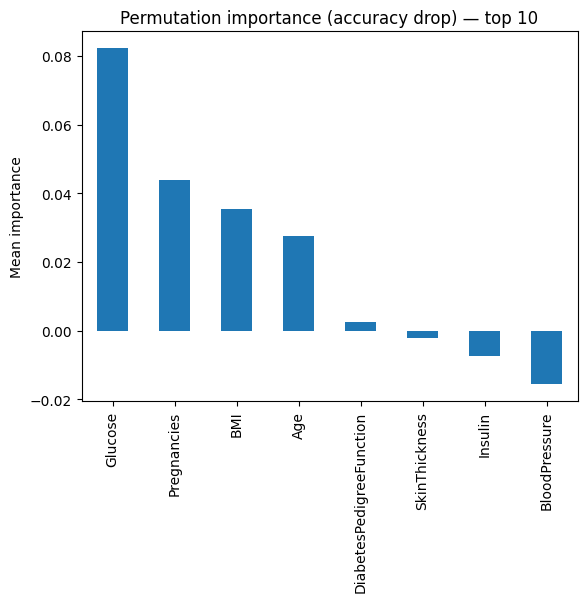

In [14]:
perm.head(10).plot(kind="bar")
plt.title("Permutation importance (accuracy drop) — top 10")
plt.ylabel("Mean importance")
plt.show()


## ۷) نگاه شهودی: محاسبه دستی کیفیت شکاف (مثال ساده)

برای ساخت شهود، روی یک دیتاست یک‌بعدی ساده **ناخالصی Gini** را حساب می‌کنیم و شکاف‌های ممکن را مقایسه می‌کنیم.

برای طبقه‌بندی دودویی با کلاس‌های {0,1} در یک گره:
- $p$ = نسبت کلاس 1
- Gini: $G = 1 - (p^2 + (1-p)^2) = 2p(1-p)$

کارهایی که انجام می‌دهیم:
1) ساخت یک دیتاست کوچک
2) امتحان همه‌ی آستانه‌های ممکن
3) انتخاب آستانه‌ای که Gini وزن‌دار را کمینه کند

---


In [15]:
# Toy 1D dataset
x = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y = np.array([0, 0, 0, 0, 1, 1, 1, 1])  # perfectly separable

def gini(y):
    if len(y) == 0:
        return 0.0
    p = np.mean(y == 1)
    return 1.0 - (p**2 + (1-p)**2)

def weighted_gini(y_left, y_right):
    n = len(y_left) + len(y_right)
    return (len(y_left)/n)*gini(y_left) + (len(y_right)/n)*gini(y_right)

# Candidate thresholds between sorted unique x values
thresholds = [(x[i] + x[i+1]) / 2 for i in range(len(x)-1)]

scores = []
for t in thresholds:
    yL = y[x <= t]
    yR = y[x > t]
    scores.append((t, weighted_gini(yL, yR), gini(yL), gini(yR), len(yL), len(yR)))

scores_df = pd.DataFrame(scores, columns=["threshold", "weighted_gini", "gini_left", "gini_right", "n_left", "n_right"])
scores_df.sort_values("weighted_gini").head(10)

,threshold,weighted_gini,gini_left,gini_right,n_left,n_right
3,4.5,0.000000,0.000000,0.000000,4,4
2,3.5,0.200000,0.000000,0.320000,3,5
4,5.5,0.200000,0.320000,0.000000,5,3
1,2.5,0.333333,0.000000,0.444444,2,6
5,6.5,0.333333,0.444444,0.000000,6,2
0,1.5,0.428571,0.000000,0.489796,1,7
6,7.5,0.428571,0.489796,0.000000,7,1


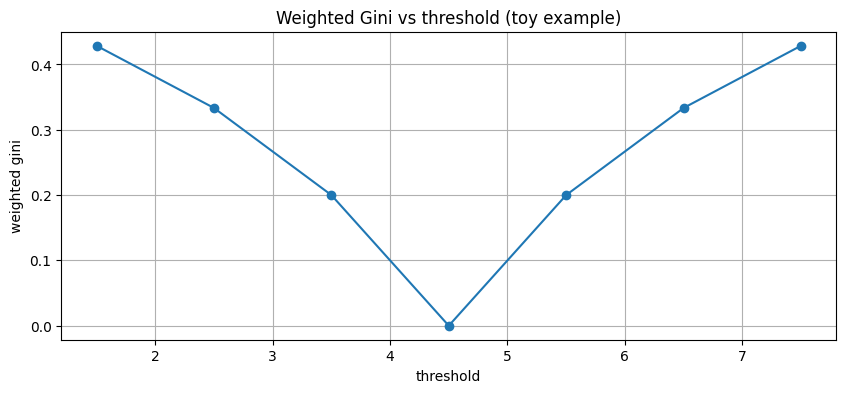

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(scores_df["threshold"], scores_df["weighted_gini"], marker="o")
plt.title("Weighted Gini vs threshold (toy example)")
plt.xlabel("threshold")
plt.ylabel("weighted gini")
plt.grid(True)
plt.show()


## ۸) تنظیم ابرپارامترها (طبقه‌بندی) + مسیر هرس‌سازی

تنظیم می‌کنیم:
- `max_depth`
- `min_samples_leaf`
- `ccp_alpha` (هرس‌سازی پسین)

یک روند رایج:
1) با `cost_complexity_pruning_path` مقادیر کاندید `ccp_alpha` را استخراج کنید
2) یک گرید کوچک بسازید و با اعتبارسنجی متقابل بهترین را انتخاب کنید

---


In [17]:
# Get pruning path alphas from the base model (on training data only!)
base_tree = DecisionTreeClassifier(random_state=42)
base_tree.fit(X_train.fillna(X_train.median(numeric_only=True)), y_train)

path = base_tree.cost_complexity_pruning_path(X_train.fillna(X_train.median(numeric_only=True)), y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas[:10], ccp_alphas[-5:]

(array([0.        , 0.00144676, 0.0015625 , 0.00160256, 0.00162037,
        0.00168011, 0.00169917, 0.00180845, 0.00231481, 0.00231481]),
 array([0.01062242, 0.01256628, 0.01346112, 0.0295121 , 0.08594835]))

In [18]:
# Build a tuning pipeline (imputer + tree)
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_grid = {
    "model__max_depth": [2, 3, 4, 5, 6, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__ccp_alpha": np.unique(np.round(ccp_alphas, 6))[:20],  # keep grid manageable
    "model__criterion": ["gini", "entropy"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'model__ccp_alpha': np.float64(0.0),
  'model__criterion': 'gini',
  'model__max_depth': 2,
  'model__min_samples_leaf': 1},
 np.float64(0.7326686656671664))

In [19]:
best_clf = gs.best_estimator_
y_pred_best = best_clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Test accuracy: 0.7135416666666666
              precision    recall  f1-score   support

    Diabetic       0.75      0.27      0.40        67
Non-Diabetic       0.71      0.95      0.81       125

    accuracy                           0.71       192
   macro avg       0.73      0.61      0.60       192
weighted avg       0.72      0.71      0.67       192




## ۹) CART با ویژگی‌های رده‌ای (drug200)

بسیاری از دیتاست‌های جدولی ویژگی‌های رده‌ای دارند. CART کلاسیک می‌تواند روی دسته‌ها با آزمون عضویت در زیرمجموعه‌ها شکاف بزند.
در بسیاری از کتابخانه‌ها (از جمله scikit-learn) روند عملی این است:

- ستون‌های رده‌ای را شناسایی کنید
- `OneHotEncoder` را اعمال کنید (یا اگر ترتیب معنا دارد از ordinal استفاده کنید)
- درخت را روی ماتریس کدگذاری‌شده آموزش دهید

از `drug200.csv` به‌عنوان مثال استفاده می‌کنیم.

---


In [20]:
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [21]:
X = df_drug.drop(columns=["Drug"])
y = df_drug["Drug"]

cat_cols = ["Sex", "BP", "Cholesterol"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

clf_drug = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=2))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf_drug.fit(X_train, y_train)
y_pred = clf_drug.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.98
              precision    recall  f1-score   support

       DrugY       0.96      1.00      0.98        23
       drugA       1.00      1.00      1.00         6
       drugB       1.00      1.00      1.00         4
       drugC       1.00      1.00      1.00         4
       drugX       1.00      0.92      0.96        13

    accuracy                           0.98        50
   macro avg       0.99      0.98      0.99        50
weighted avg       0.98      0.98      0.98        50




## ۱۰) CART برای رگرسیون (house prices)

حالا به **DecisionTreeRegressor** می‌رویم و همان ایده‌ها را می‌بینیم:
- شکاف‌های حریصانه
- پیش‌بینی برگ به‌صورت میانگین هدف
- منظم‌سازی با محدودیت عمق/برگ و هرس‌سازی

از `house-prices.csv` استفاده می‌کنیم که ستون‌های رده‌ای مثل `Neighborhood` و `Brick` دارد.

---


In [22]:
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [23]:
X = df_house.drop(columns=["Price"])
y = df_house["Price"]

cat_cols = ["Brick", "Neighborhood"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeRegressor(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg.fit(X_train, y_train)
pred = reg.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = root_mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

mae, rmse, r2

(np.float64(17053.125), np.float64(21018.71933539244), 0.2793239671618307)

In [24]:
param_grid = {
    "model__max_depth": [2, 3, 4, 5, None],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__ccp_alpha": [0.0, 50.0, 100.0, 200.0, 500.0],  # scale depends on target magnitude
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
gs_reg = GridSearchCV(reg, param_grid=param_grid, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1)
gs_reg.fit(X_train, y_train)

gs_reg.best_params_, -gs_reg.best_score_

({'model__ccp_alpha': 0.0,
  'model__max_depth': 3,
  'model__min_samples_leaf': 2},
 np.float64(12891.869797570851))

In [25]:
best_reg = gs_reg.best_estimator_
pred = best_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", root_mean_squared_error(y_test, pred))
print("R2:", r2_score(y_test, pred))

MAE: 11431.77406832298
RMSE: 15842.380911890095
R2: 0.5905805415949494



## ۱۱) یک مثال رگرسیون دیگر (diamonds): رده‌ها با کاردینالیتی بالا و محدودیت‌های درخت

دیتاست `diamonds.csv` بزرگ‌تر است و چند ستون رده‌ای دارد (`cut`, `color`, `clarity`).
درخت تصمیم زمانی سریع بیش‌برازش می‌کند که:
- دسته‌ها/شکاف‌های ممکن زیاد باشند
- ویژگی‌ها زیاد و منظم‌سازی کم باشد
- اجازه دهیم درخت خیلی عمیق شود

یک درخت محدود آموزش می‌دهیم و عملکرد را بررسی می‌کنیم.

---


In [26]:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
df_diamonds = pd.read_csv(path_diamonds)
df_diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [27]:
# Basic setup: predict price from a subset of features
# We'll keep it light: remove ID and use common predictors.
df = df_diamonds.drop(columns=["id"])

X = df.drop(columns=["price"])
y = df["price"]

cat_cols = ["cut", "color", "clarity"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ]
)

reg_diamond = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeRegressor(
        random_state=42,
        max_depth=8,
        min_samples_leaf=50
    ))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg_diamond.fit(X_train, y_train)
pred = reg_diamond.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", root_mean_squared_error(y_test, pred))
print("R2:", r2_score(y_test, pred))

MAE: 486.87754225719925
RMSE: 885.4413952300021
R2: 0.9506815581472905



## ۱۲) مسیر تصمیم: «چرا درخت این پیش‌بینی را داد؟»

درخت‌ها یک سبک توضیح‌پذیری شفاف دارند:
- دنبال‌کردن یک نمونه از ریشه تا برگ
- فهرست‌کردن قواعد و آستانه‌ها
- نمایش آمار برگ

در scikit-learn می‌توانیم از موارد زیر استفاده کنیم:
- `apply` برای شناسه‌ی برگ
- `decision_path` برای گره‌های پیموده‌شده
- `export_text` برای قواعد خوانا

این بخش را با طبقه‌بند تنظیم‌شده‌ی diabetes نشان می‌دهیم.

---


In [28]:
# Use the tuned diabetes classifier if available; otherwise fall back to the baseline clf
try:
    explainer_pipe = best_clf
except NameError:
    explainer_pipe = clf

best_tree = explainer_pipe.named_steps["model"]

# Use the saved diabetes test set (prevents feature-name mismatch if X_test was overwritten later)
X_test_used = X_test_diabetes
y_test_used = y_test_diabetes

X_test_imp = explainer_pipe.named_steps["imputer"].transform(X_test_used)

# Pick one sample
i = 0
x0 = X_test_used.iloc[[i]]
y0_true = y_test_used.iloc[i]

leaf_id = best_tree.apply(X_test_imp[[i]])
node_indicator = best_tree.decision_path(X_test_imp[[i]])
feature = best_tree.tree_.feature
threshold = best_tree.tree_.threshold

print("True label:", y0_true)
print("Predicted :", explainer_pipe.predict(x0)[0])
print("Leaf id   :", leaf_id[0])

# Extract the decision rules along the path
node_index = node_indicator.indices[node_indicator.indptr[0]: node_indicator.indptr[1]]
for node_id in node_index:
    if leaf_id[0] == node_id:
        print("-> reached leaf node", node_id)
        continue
    f = feature[node_id]
    t = threshold[node_id]
    fname = feature_names_diabetes[f]
    xval = x0.iloc[0, f]
    if xval <= t:
        print(f"node {node_id}: ({fname} <= {t:.3f}) [value={xval}] -> go left")
    else:
        print(f"node {node_id}: ({fname} >  {t:.3f}) [value={xval}] -> go right")


True label: Non-Diabetic
Predicted : Non-Diabetic
Leaf id   : 2
node 0: (Glucose <= 154.500) [value=90] -> go left
node 1: (Age <= 28.500) [value=24] -> go left
-> reached leaf node 2



## ۱۳) نکته‌های عملی و بهترین رویه‌ها

### ۱۳.۱ نشت داده (Data leakage)
درخت‌ها انعطاف‌پذیرند و می‌توانند نشت داده را شدیداً بهره‌برداری کنند.
مثال‌ها:
- ویژگی‌های پس از رخداد (مثلاً آزمایش‌هایی که بعد از تشخیص گرفته شده‌اند)
- شناسه‌هایی که زمان/گروه را کُد می‌کنند
- نشت هدف در پیش‌پردازش (فیت‌کردن imputer/encoder روی کل داده)

**راهکار:** همیشه پیش‌پردازش را فقط روی داده‌ی آموزش فیت کنید (با `Pipeline`).

### ۱۳.۲ ناپایداری شکاف‌ها
تغییرات کوچک داده می‌تواند شکاف‌ها را تغییر دهد (واریانس بالا).
راهکارها:
- هرس‌سازی / `min_samples_leaf`
- استفاده از ensembleها (Random Forest / Gradient Boosting) وقتی دقت مهم است
- اعتبارسنجی متقابل برای انتخاب مدل

### ۱۳.۳ مقادیر گمشده
CART کلاسیک می‌تواند با surrogate splits با مقادیر گمشده کنار بیاید، اما درخت‌های scikit-learn به‌طور بومی با NaN کار نمی‌کنند.
از imputation (median / most frequent) در پایپلاین استفاده کنید.

### ۱۳.۴ چه زمانی از یک درخت تکی استفاده نکنیم؟
یک CART تکی مناسب است وقتی:
- تفسیرپذیری مهم‌تر از دقت است
- قواعد ساده می‌خواهید
- یک baseline سریع لازم دارید

اما برای دقت/پایداری بیشتر، درخت‌ها معمولاً در ensembleها استفاده می‌شوند (فصل ۶).

---



## ۱۴) تمرین‌ها (با راهنما)

1) **تنظیم طبقه‌بندی (diabetes):**  
   `max_depth`، `min_samples_leaf` و `ccp_alpha` را طوری تنظیم کنید که **ROC-AUC** بیشینه شود (نه accuracy).  
   - راهنما: از `scoring="roc_auc"` استفاده کنید و برچسب مثبت را مشخص کنید.

2) **آزمایش عدم‌توازن کلاس:**  
   یک نسخه‌ی نامتوازن از diabetes بسازید (مثلاً downsample یک کلاس). مقایسه کنید:
   - درخت ساده
   - درخت با `class_weight="balanced"`  
   با **balanced accuracy** و **F1-score** ارزیابی کنید.

3) **پایداری رگرسیون (house prices):**  
   درخت رگرسیون را با معیارهای زیر مقایسه کنید:
   - `criterion="squared_error"` (پیش‌فرض)
   - `criterion="absolute_error"` (پیش‌بینی میانه)  
   کدام‌یک نسبت به outlierها در `Price` مقاوم‌تر است؟

4) **تفسیرپذیری:**  
   برای ۵ نمونه از داده‌ی آزمون مسیر تصمیم را چاپ کنید و با زبان طبیعی خلاصه کنید:  
   «این نمونه عمدتاً به‌خاطر بالا بودن Glucose و بالاتر بودن BMI از ... دیابتی پیش‌بینی شده است.»

5) **از صفر:**  
   یک regression stump با عمق ۱ بسازید که بهترین شکاف را با کمینه‌کردن SSE پیدا کند و MAE آن را با یک درخت کامل مقایسه کنید.

---



## ۱۵) جمع‌بندی

اکنون باید بتوانید:
- CART را به‌عنوان تقسیم‌بندی بازگشتی حریصانه با انتخاب شکاف بر پایه ناخالصی توضیح دهید
- معیارهای طبقه‌بندی و رگرسیون را از هم تفکیک کنید
- پیچیدگی را با هرس‌سازی پیشین و هرس‌سازی پیچیدگی-هزینه کنترل کنید
- برای مقادیر گمشده و ویژگی‌های رده‌ای پایپلاین بسازید
- با مصورسازی، اهمیت ویژگی و مسیر تصمیم درخت را تفسیر کنید

در درس‌های بعدی فصل ۵، عمیق‌تر وارد **بیش‌برازش**، **هرس‌سازی** و **گونه‌های مختلف درخت** (CHAID، C4.5/C5.0، model trees) می‌شوید.

---
